# Beo model validation

Make figures of model validation of escript for heat conduction and heat advection by comparing to analytical solutions


In [31]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as pl
import scipy.special

/usr/lib/python2.7/dist-packages/simplejson/encoder.py:262: DeprecationWarning: Interpreting naive datetime as local 2018-11-15 18:33:50.094802. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## import escript modules

We will use the generic finite element code escript for numerical solution of the heat transfer equation. Get escript here: https://launchpad.net/escript-finley

This notebook also assumed the escript modules added to your system path and are finable by Python. See the guide below on how to do this:


### Downloading Beo

* click the download link on the right for a zip file of the source code
* or clone the repository

### Installing & running 

* Install Escript

    - get the code here: https://launchpad.net/escript-finley
    - an installation guide can be found here: http://esys.geocomp.uq.edu.au/docs

* Unzip the beo source code  
* Navigate to the directory where you have installed escript. Go to the subdirectory bin (``python-escript/bin/``) and run Beo by executing the following command from the command line:
	
````bash
./run-escript beo_dir/beo.py
````	

Where ``beo_dir`` is the directory where you have saved Beo.

Alternatively use the command 

````bash
./run-escript -e
````

This will show you three lines that define environment variables that your system needs to be able to find the location of escript. Add these lines to your .bashrc (Ubuntu linux) or profile file in your home directory. After adding these lines and logging out and in again, you can start beo by going to the directory where the beo code is located (so not to the escript/bin directory) and start beo.py like any regular python code:

````bash
python beo.py model_parameters/model_parameters.py
````

where ``model_parameters/model_parameters.py`` is a file containing all model parameters. An example file called ``model_parameters.py`` is located in the directory ``model_parameters``.

In [32]:
import esys.escript as es
import esys.escript.linearPDEs as linearPDEs
from esys.finley import Rectangle

/usr/lib/python2.7/dist-packages/simplejson/encoder.py:262: DeprecationWarning: Interpreting naive datetime as local 2018-11-15 18:33:50.110222. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## Set up parameters:

In [33]:
# make grid of k and thickness
zs = np.linspace(10, 1000, 100)
T0 = 0.0
T1 = 30.0
L = 1000.0
rho = 1000.0
c = 900.0
K = 2.5

qs = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0]
cs = ['gray', 'blue', 'brown', 'green', 'orange', 'red']

year = 365.25 * 24 * 60 * 60

/usr/lib/python2.7/dist-packages/simplejson/encoder.py:262: DeprecationWarning: Interpreting naive datetime as local 2018-11-15 18:33:50.254641. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## time discretization of the heat flow equation

choose 'implicit' or 'explicit' below

note that for explicit methods the timestep size is constrained by the Courant_Friedrich-Levy (CFL) condition: 

$$CFL = q \Delta t / \Delta x$$

where q is flux (m/s), $\Delta t$ is the timestep size (s) and $\Delta x$ is the grid size. The CFL number should be less than 1.

In [ ]:
discretization == 'explicit'

## Analytical solution

Calculate temperature using analytical solution by Bredehoeft & Papaopulos (1965) WRR:

$$T = \dfrac{e^{((\beta \: z )/ L)} - 1}{e^{\beta} - 1} \Delta T + T_0$$

and

$$\beta = -c \rho q L / K$$

where z is depth (m), $\Delta T$ is the temperature difference between the top and the bottom of the domain (K), $T_0$ is the temperature at the top of the domain, c is heat capacity (J kg-1 K-1), $\rho$ is density, L is length (m) and K is thermal conductivity (W m-1 K-1).

In [34]:
Ts = []
for q in qs:
    q_ms = q / (365.25 * 24 * 60 * 60.0)
    beta = -c * rho * q_ms * L / K
    Tr = (np.exp((beta * zs) / L) - 1.0) / (np.exp(beta) - 1.0)
    T = Tr * (T1 - T0) + T0
    
    Ts.append(T)

/usr/lib/python2.7/dist-packages/simplejson/encoder.py:262: DeprecationWarning: Interpreting naive datetime as local 2018-11-15 18:33:50.397230. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## Set up numerical model

In [35]:
def convert_to_array(u, no_coords=False):

    """
    Return the x,y coordinates and the value of escript variable u as
    a numpy array
    """

    coords = u.getFunctionSpace().getX()
    x, y = coords[0], coords[1]

    xy = np.array([x.toListOfTuples(), y.toListOfTuples()]).T

    u_array = np.array(u.toListOfTuples())

    assert len(u_array.shape) == 1

    if no_coords is True:
        return u_array
    else:
        return xy, u_array
    

nx = 200
mesh = Rectangle(l0=L, l1=1, n0=nx, n1=1)

hf_pde = linearPDEs.LinearPDE(mesh)

xyz = mesh.getX()

hf_pde.getSolverOptions().setSolverMethod(es.SolverOptions.GMRES)

top_bnd = es.whereZero(xyz[0] - es.sup(xyz[0]))
bottom_bnd = es.whereZero(xyz[0] - es.inf(xyz[0]))
specified_T_loc = es.wherePositive(top_bnd) + es.wherePositive(bottom_bnd)
specified_T = es.wherePositive(top_bnd) * T1 + es.wherePositive(bottom_bnd) * T0


T_nums = []

for q in qs:
    
    print 'running numerical model for q=%0.2f' % q
    
    # set PDE coefficients, steady-state flow equation
    q_vector = es.Vector((-q / year, 0), es.Function(mesh))
    
    A = K * es.kronecker(mesh)
    C = rho * c * q_vector
    D = 0
    Y = 0
    hf_pde.setValue(A=A, C=C, D=D, Y=Y,
                r=specified_T,
                q=specified_T_loc)
    
    T_num = hf_pde.getSolution()
    
    T_array = convert_to_array(T_num, no_coords=True)
    
    T_nums.append(T_array)
    
    print 'modeled T = ', T_num, ', mean = ', T_array.mean()
    


running numerical model for q=0.00
modeled T =  Summary: inf=0 sup=30 data points=402 , mean =  15.028398286099513
running numerical model for q=0.01
modeled T =  Summary: inf=0 sup=30 data points=402 , mean =  15.283650703888885
running numerical model for q=0.10
modeled T =  Summary: inf=0 sup=30 data points=402 , mean =  17.777894954933586
running numerical model for q=0.50
modeled T =  Summary: inf=0 sup=30 data points=402 , mean =  24.791774645874202
running numerical model for q=1.00
modeled T =  Summary: inf=0 sup=30 data points=402 , mean =  27.309004180129932
running numerical model for q=5.00
modeled T =  Summary: inf=0 sup=30 data points=402 , mean =  29.40203004445879


/usr/lib/python2.7/dist-packages/simplejson/encoder.py:262: DeprecationWarning: Interpreting naive datetime as local 2018-11-15 18:33:50.539144. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [36]:
#T_list = [convert_to_array(T_num, no_coords=True) for T_num in T_nums]
x_num, _ = convert_to_array(T_num)


/usr/lib/python2.7/dist-packages/simplejson/encoder.py:262: DeprecationWarning: Interpreting naive datetime as local 2018-11-15 18:33:52.634185. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [37]:
x_num.shape

(402, 2)

/usr/lib/python2.7/dist-packages/simplejson/encoder.py:262: DeprecationWarning: Interpreting naive datetime as local 2018-11-15 18:33:52.639968. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## Show results in figure:

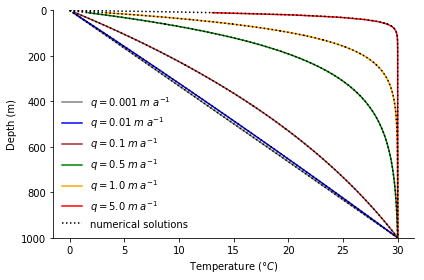

/usr/lib/python2.7/dist-packages/simplejson/encoder.py:262: DeprecationWarning: Interpreting naive datetime as local 2018-11-15 18:33:52.783660. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [38]:
######
fig, ax = pl.subplots(1, 1)

for T, q, color in zip(Ts, qs, cs):
    label = r'$q=' + str(q) + '\;m\;a^{-1}$'
    ax.plot(T, zs, color=color, label=label, ls='-', lw=1.5)


for i, Tn, color in zip(itertools.count(), T_nums, cs):
    if i == 0:
        label = 'numerical solutions'
    else: 
        label = None
    ax.plot(Tn, x_num[:, 0], color='k', ls=':', label=label)

ax.legend(loc='lower left', frameon=False)
ax.set_xlabel(r'Temperature ($\degree C$)')
ax.set_ylabel('Depth (m)')
ax.set_ylim(L, 0)

#ax.grid()

fig.tight_layout()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('fig/heat_advection_validation.pdf', dpi=200)


## Analytical transient conduction

We check whether our numerical model is correct by comparing our solution to an analytical solution for the cooling of an intrusive in the subsurface. The solution for temperature change of an initially perturbed temperature field is [@Carslaw1959]:

\begin{equation}
    T(z,t) = T_b + \frac{T_i - T_b}{2} \left( erf \left(\frac{L-z}{2 \sqrt{\kappa t}} \right) + erf \left(\frac{L+z}{2 \sqrt{\kappa t}} \right) \right)
\end{equation}

where *T~b~* is the background temperature, *T~i~* is the temperature of the intrusive, *L* is the length of the intrusive.

Following [@Ehlers2005] we use this equation to simulate cooling of an intrusive in the subsurface. The numerical and analytical solutions for cooling are shown in Figure 1. The Intrusive body has an initial temperature of 700 degrees C, and stretches from 0 to 500 m distance. The background temperature is 50 degrees C. The solutions match to within ... degree C and show the gradual decrease in temperatures. 

In [39]:
def analytical_solution_temperature_change(z, t, L, Ts, Tb, kappa):

    """
    z = distance (m)
    t = time (sec)
    L = size of intrusion (m)
    Ts = surface temperature (at intrusion)
    Tb = background temperature (K)
    kappa = thermal diffusivity
    """

    temperature = Tb + (Ts - Tb) / 2.0 * (
        scipy.special.erf((L - z) / (2 * np.sqrt(kappa*t))) +
        scipy.special.erf((L + z) / (2 * np.sqrt(kappa * t))))

    return temperature

/usr/lib/python2.7/dist-packages/simplejson/encoder.py:262: DeprecationWarning: Interpreting naive datetime as local 2018-11-15 18:33:53.484549. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [72]:
L = 500
# thermal diffusivity in Ehlers (2005)
kappa = 32.0 / year
Kelvin = 273.15
# surface T
Ts = 700.0 + Kelvin
# background temp
Tb = 50.0 + Kelvin
# density
rho = 2000.0
# specific heat capacity
cp = 900.0
# estimate K from Ehlers(2005) thermal diffusivity
K = kappa * rho * cp

nx = 2000
dx = 5.0
xis = np.arange(nx) * dx + dx / 2.0

ts  = [20 * year, 1e3*year, 1e4*year]

Ti_an = [analytical_solution_temperature_change(xis, t, L, Ts, Tb, kappa) for t in ts]

/usr/lib/python2.7/dist-packages/simplejson/encoder.py:262: DeprecationWarning: Interpreting naive datetime as local 2018-11-15 18:58:19.000694. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [73]:

#nx = 200
mesh = Rectangle(l0=xis.max(), l1=1, n0=nx, n1=1)

hf_pde = linearPDEs.LinearPDE(mesh)

xyz = mesh.getX()

Kb = xyz[0] * 0.0
cb = xyz[0] * 0.0

hf_pde.getSolverOptions().setSolverMethod(es.SolverOptions.GMRES)

top_bnd = es.whereZero(xyz[0] - es.sup(xyz[0]))
bottom_bnd = es.whereZero(xyz[0] - es.inf(xyz[0]))
#specified_T_loc = es.wherePositive(bottom_bnd)
#specified_T = es.wherePositive(top_bnd) * Ts + es.wherePositive(bottom_bnd) * Tb

T_num = es.whereNegative(xyz[0] - L) * Ts + es.whereNonNegative(xyz[0] - L) * Tb

T_nums = []

dt = 10 * year
nt = 1001

t_nums = np.arange(nt) * dt

for nti in range(nt):
    
    if discretization == 'implicit':
        # set PDE coefficients, transient heat flow equation
        A = dt * K * es.kronecker(mesh)
        #C = dt * rho_f * c_f * q_vector
        #C = 0
        D = rho * cp
        Y = rho * cp * T_num
        
    elif discretization == 'explicit':
        
        D = rho * cp
        X = dt * K * es.grad(T_num)
        Y = rho * cp * T_num
        
    hf_pde.setValue(A=A, D=D, Y=Y)
    
    T_num = hf_pde.getSolution()
    
    T_array = convert_to_array(T_num, no_coords=True)
    
    T_nums.append(T_array)
    
    #print 'modeled T = ', T_num, ', mean = ', T_array.mean()
    
x_num, _ = convert_to_array(T_num)

/usr/lib/python2.7/dist-packages/simplejson/encoder.py:262: DeprecationWarning: Interpreting naive datetime as local 2018-11-15 18:58:22.487747. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [74]:
len(x_num)

4002

/usr/lib/python2.7/dist-packages/simplejson/encoder.py:262: DeprecationWarning: Interpreting naive datetime as local 2018-11-15 18:58:31.080710. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


10.0 numerical solution
1000.0 
10000.0 


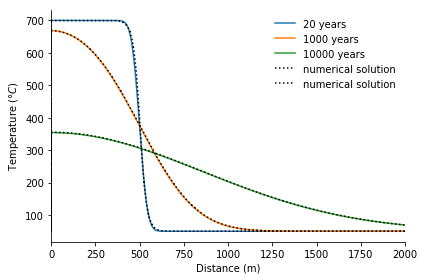

/usr/lib/python2.7/dist-packages/simplejson/encoder.py:262: DeprecationWarning: Interpreting naive datetime as local 2018-11-15 19:06:37.040158. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [89]:
fig, ax = pl.subplots(1, 1)
for T, t in zip(Ti_an, ts):
    ax.plot(xis, T - Kelvin, lw=1.5, label='%0.0f years' %(t/year))
    
ind_plot = [1, 100, 1000]
for i, j in enumerate(ind_plot):
    if i == 0:
        label = 'numerical solution'
        #label = 'a'
        ax.plot(x_num, T_nums[j] - Kelvin, color='black', ls=':', label=label)
    else:
        label=''
        ax.plot(x_num, T_nums[j] - Kelvin, color='black', ls=':')
    
    print t_nums[j] / year, label

ax.legend(frameon=False)
ax.set_xlim(0, 2000)

ax.set_ylabel(r'Temperature ($\degree C$)')
ax.set_xlabel('Distance (m)')

fig.tight_layout()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('fig/heat_conduction_validation.pdf', dpi=200)
